### For any given size ratio (w, h), resize the given image and rescale the bounding box.
### Padding the image with black? pixels, random assign to the left/right or above/below.
#### Inputs: scaling factor (which controls the actual size of the output image); txt file which contains the image path; make an output directory; create an output path txt

### Different situations: 
#### 1. original w and h both smaller than the desired size
#### 2. either w or h smaller than the desired size
#### 3. both w or h larger than the desired size

In [1]:
import os
import numpy as np
import random
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import math

from collections import namedtuple
from pathlib import Path
from pyquery import PyQuery as pq

import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [2]:
# get the image ID (just the ID, not .jpg or path)
# generate image paths and raw xml bbox paths
img_path = os.listdir('./image/mini_image/')
ID_list = [path.split('.')[0] for path in img_path] 
with open('./data/id.txt', 'w') as fout:
    for ID in ID_list:
        fout.write(f"{ID}\n")
with open('./data/img.txt', "w") as fout:
    for ID in ID_list:
        path = './image/mini_image/' + ID + '.jpg'
        fout.write(f"{path}\n")
with open('./data/bbox.txt', "w") as fout:
    for ID in ID_list:
        path = './bbox/mini_bbox/' + ID + '.xml'
        fout.write(f"{path}\n")

In [2]:
Coor = namedtuple('Coor', ['xmin', 'ymin', 'xmax', 'ymax'])
NormCoor = namedtuple('NormCoor', ['class_name','xcenter', 'ycenter', 'width', 'height'])
Size = namedtuple('Size', ['w', 'h'])
Box = namedtuple('Box', ['name', 'size', 'coor_lst'])

# get image path and bbox (raw xml) path
def get_path(ID):
    img_path = './image/mini_image/' + ID + '.jpg'
    xml_path = './bbox/mini_bbox/' + ID + '.xml'
    new_img_path = './image/' + ID + '.jpg'
    new_txt_path = './bbox/' + ID + '.txt'
    
    return img_path, xml_path, new_img_path, new_txt_path

# resize the raw image to fit the desired size
def scale_size(w, h, raw_h, raw_w):
    if raw_h < h and raw_w < w:
        scaled_h, scaled_w = raw_h, raw_w # if raw image is smaller, keep its original h and w
    else: # compress along the dim which is proportionally larger
        scale_ratio = min(h/raw_h, w/raw_w)
        scaled_h, scaled_w = math.floor(raw_h * scale_ratio), math.floor(raw_w * scale_ratio)
    return (scaled_h, scaled_w)

# randomly assign the padding area
# padding with black
def random_padding(h, w, scaled_img):
    scaled_h, scaled_w = scaled_img.shape[0], scaled_img.shape[1]
    h_padding = max(0, h - scaled_h)
    w_padding = max(0, w - scaled_w)
    scaled_h, scaled_w = scaled_img.shape[0], scaled_img.shape[1]
    top = random.randint(0, h_padding)
    left = random.randint(0, w_padding)
    canvas = np.zeros((h, w, 3)).astype(int)
    canvas[top:top+scaled_h, left:left+scaled_w,:] = scaled_img
    return canvas, top, left # the padded image and the offsets


In [3]:
# update the bounding boxes, reading from original xml file
# output into txt files
def get_cordinates(filename):
    doc = pq(filename=filename, parser='xml')
    raw_list = []
    raw_list.append(doc('filename')[0].text)
    size = [int(doc('width')[0].text), int(doc('height')[0].text)]
    raw_list.append(size) # [width, height]
    class_name = doc('folder')[0].text

    for obj in doc('object'):
        obj_name = pq(obj)('name')[0].text
        if obj_name == class_name:
            boxes = pq(obj)('bndbox')
            assert len(boxes) == 1
            xylist = [int(boxes('xmin')[0].text),
                     int(boxes('ymin')[0].text),
                     int(boxes('xmax')[0].text),
                     int(boxes('ymax')[0].text)]
            raw_list.append(xylist)
        else:
            pass
    return wrap(raw_list)

def wrap(raw_list):
    name = raw_list[0]
    size = Size(*raw_list[1])
    coor_lst = [Coor(*l) for l in raw_list[2:]]
    return Box(name, size, coor_lst)

def wrap_updated(raw_list, new_coor_list):
    name = raw_list[0]
    size = Size(*raw_list[1])
    coor_lst = [Coor(*l) for l in new_coor_list]
    return Box(name, size, coor_lst)

def update_coor_list(xml_path, scaled_ratio, top, left):
    coor_list = get_cordinates(xml_path)[2]
    new_coor_list = []
    for coor in coor_list:
        new_xmin = int(coor.xmin * scaled_ratio + left)
        new_xmax = int(coor.xmax * scaled_ratio + left)
        new_ymax = int(coor.ymax * scaled_ratio + top)
        new_ymin = int(coor.ymin * scaled_ratio + top)
        assert new_xmax <= w and new_ymax <= h
        new_xylist = [new_xmin, new_ymin, new_xmax, new_ymax]
        new_coor_list.append(new_xylist) 
    return new_coor_list

def normalize_coor(box):
    bb_list = []
    for coor in box.coor_lst:
        class_name = box.name.split("_")[0]
        xcenter = (coor.xmin + coor.xmax) / 2 / box.size.w
        ycenter = (coor.ymin + coor.ymax) / 2 / box.size.h
        width = (coor.xmax - coor.xmin) / box.size.w
        height = (coor.ymax - coor.ymin) / box.size.h
        norm_coor = NormCoor(class_name, xcenter, ycenter, width, height)
        bb_list.append(norm_coor)
    return bb_list

def write_to_txt(bb_list, path):
    path = Path(path)
    file_name = bb_list[0].class_name
    with path.open("w") as fout:
        for coor in bb_list:
            fout.write(f"{file_name} {coor.xcenter} {coor.ycenter} {coor.width} {coor.height}\n")
            

In [4]:
# wrapper function
def data_prep(ID, w, h):
    """
    ID: the shared ID for the image and the bounding box
    w, h: the desired output image size
    """
    # resize and pad the image (if needed)
    img_path, xml_path = get_path(ID)[0], get_path(ID)[1]
    # output path
    new_img_path, new_txt_path = get_path(ID)[2], get_path(ID)[3]
    
    raw_img = cv2.imread(img_path)
    raw_h, raw_w = raw_img.shape[0], raw_img.shape[1]
    scaled_h, scaled_w = scale_size(w, h, raw_h, raw_w)
    scaled_img = cv2.resize(raw_img, (scaled_w, scaled_h))
    padded_img, top, left = random_padding(h, w, scaled_img)
    
    # save padded image
    cv2.imwrite(new_img_path, padded_img)
    
    # update the bounding box
    scaled_ratio = scaled_w / w
    raw_list = get_cordinates(xml_path)
    updated_list = update_coor_list(xml_path, scaled_ratio, top, left)
    box = wrap_updated(raw_list, updated_list)
    bb_list = normalize_coor(box)
    write_to_txt(bb_list, new_txt_path)
    

### Sample padded image and updated bounding boxes

In [5]:
ID = 'n02777734_12'
w = 300
h = 300
data_prep(ID, w, h)

In [6]:
im = np.array(Image.open(get_path(ID)[2]))
raw_h, raw_w = im.shape[0], im.shape[1]

In [7]:
bbox_list = []
bbox = []
with open(get_path(ID)[3], "r") as fin:
    for line in fin:
        xcenter = float(list(line.strip().split(" "))[1])
        ycenter = float(list(line.strip().split(" "))[2])                       
        width = float(list(line.strip().split(" "))[3])                       
        height = float(list(line.strip().split(" "))[4]) 
        xmin = (xcenter - width / 2) * raw_w
        ymax = (ycenter + height / 2) * raw_h
        bbox = [xmin, ymax]
        bbox_list.append(bbox)
bbox_list

[[87.12574850299401, 70.2], [88.92215568862275, 118.2]]

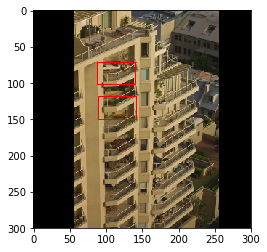

In [8]:
fig,ax = plt.subplots(1)

ax.imshow(im)
rect = patches.Rectangle((bbox_list[0][0],bbox_list[0][1]),width*raw_w,height*raw_h,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((bbox_list[1][0],bbox_list[1][1]),width*raw_w,height*raw_h,linewidth=1,edgecolor='r',facecolor='none')

ax.add_patch(rect)
ax.add_patch(rect2)

plt.show()

In [12]:
# convert selected images and bounding boxes
# for now, the desired input image size is 360 * 640
ID_list = []
with open("./data/id.txt", "r") as fin:
    for line in fin:
        ID_list.append(line.strip())

w = 640
h = 360
for ID in ID_list:
    data_prep(ID, w, h)
    